# Project 3: Web Scraping and NLP: Depression vs Bipolar

## Problem description

Provided with numerous posts on Reddit, I had a binary classification problem on hand to see if a difference could be infered between depression and bipolar posts. After scraping two subreddits, I compared Naive Bayes, Logistic Regression, and KNN models to finetune one that would perform the best. My main concern was measuring the accuracy of the model. After, choosing my model, I went ahead and train my model to make real time predictions. In the 'real_time_predictions' subfolder you will find a code that if ran will tell you with some accuracy whether the person who wrote a paragraph about how they feel should be treated for bipolar or depression.

### Project Structure:
- Notebook 1. Web APIs and Data Collection
- Notebook 2. EDA, Data Cleaning
- Notebook 3. Pre-Processing
- Notebook 4a. Modeling: Naive-Bayes
- Notebook 4b. Modeling: Logistic Regressoin
- Notebook 4c. Modeling: KNN
- Notebook 5. Model Evaluation

## Models Evaluation

I picked two of my best models to evaluate and compare the metrics. My main metric to optimize was accuracy. This is because I don't trully have a false negative or a false positive in this problem. Both depression and bipolar can be viewed as important of a result as the other. 

In [57]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [3]:
df = pd.read_csv('../data/data_pre_processed.csv')

In [4]:
df.dropna(inplace = True)

### Prepare the data for modeling

In [5]:
y = df['subreddit'].map({'depression':0, 'bipolar':1})
y.value_counts(normalize = True) #Null accuracy

0    0.540022
1    0.459978
Name: subreddit, dtype: float64

In [6]:
X = df['title_selftext']
X.head()

0    power like shit never stop coming get frustrat...
1    feel sick stomach first foremost diagnosed fee...
2    people cruel really suck tell someone sad make...
3    bother motivation learn grow part kind relatio...
4    today birthday shall kill nutshell parent aban...
Name: title_selftext, dtype: object

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = .33)

### Instantiate and Fit the models

In [8]:
cvec = CountVectorizer(max_features = 5000, min_df = 2, max_df = .8, ngram_range = (1,2))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [9]:
knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_train_cvec, y_train)

mnb_model = MultinomialNB()

mnb_model.fit(X_train_cvec, y_train);

In [10]:
print('The train and test accuracy from KNN model are the following:')
print(knn_model.score(X_train_cvec, y_train))
print(knn_model.score(X_test_cvec, y_test))
print()
print('The train and test scores accuracy for Multinomial Naive Bayes are as follows:')
print(mnb_model.score(X_train_cvec, y_train))
print(mnb_model.score(X_test_cvec, y_test))

The train and test accuracy from KNN model are the following:
0.7880184331797235
0.6232464929859719

The train and test scores accuracy for Multinomial Naive Bayes are as follows:
0.8462804476629362
0.800935203740815


Both of our models do better than the null accuracy. We can see that the Multinomial Naive Bayes outperforms the KNN model. The accuracy score is the percentage of correct predictions. 

### Making predictions

In [11]:
#KNN model predictions
prediction_knn = knn_model.predict(X_test_cvec)
#Multinomial Naive Bayes predictions
prediction_mnb = mnb_model.predict(X_test_cvec)

In [12]:
#KNN predicted probability 
proba_knn = knn_model.predict_proba(X_test_cvec)
#Multinomial NB predicted probability
proba_mnb = mnb_model.predict_proba(X_test_cvec)

In [22]:
#saving the confusion_matrices
cm_knn = confusion_matrix(y_test, prediction_knn)
cm_mnb = confusion_matrix(y_test, prediction_mnb)

### Evaluation

In [13]:
cm_knn_df = pd.DataFrame(cm_knn, 
             columns=['predicted depression', 'predicted bipolar'],
             index=['actual depression', 'actual bipolar'])
print('Confusion matrix for KNN model:')
cm_knn_df

,predicted depression,predicted bipolar
actual depression,376,432
actual bipolar,135,554


In [14]:
cm_mnb_df = pd.DataFrame(cm_mnb, 
             columns=['predicted depression', 'predicted bipolar'],
             index=['actual depression', 'actual bipolar'])
print('Confusion matrix for Multinomial NB model:')
cm_mnb_df

,predicted depression,predicted bipolar
actual depression,699,109
actual bipolar,196,493


In [19]:
print('KNN is wrong {}% of the time'.format(round((1 - metrics.accuracy_score(y_test, prediction_knn))*100),2))
print()
print('MNB is wrong {}% of the time'.format(round((1 - metrics.accuracy_score(y_test, prediction_mnb))*100),2))

KNN is wrong 38.0% of the time

MNB is wrong 20.0% of the time


In [23]:
#unravel the confusion matrix to be able to calculated the sensitivity and specificity

#KNN
TP_knn = cm_knn[1, 1]
TN_knn = cm_knn[0, 0]
FP_knn = cm_knn[0, 1]
FN_knn = cm_knn[1, 0]

#MNB
TP_mnb = cm_mnb[1, 1]
TN_mnb = cm_mnb[0, 0]
FP_mnb = cm_mnb[0, 1]
FN_mnb = cm_mnb[1, 0]


In this case we would want to optimize for both sensitivity and specificity. The KNN model is better at predicting bipolar but not so good at predicting depression. While the MNB model is more even at optimizing for both. 

In [31]:
print('Sensitivity for KNN:{}'.format(metrics.recall_score(y_test, prediction_knn)))
print('Specificity for KNN:{}'.format(TN_knn / (TN_knn + FP_knn)))
print()
print('Sensitivity for MNB:{}'.format(metrics.recall_score(y_test, prediction_mnb)))
print('Specificity for MNB:{}'.format(TN_mnb / (TN_mnb + FP_mnb)))

Sensitivity for KNN:0.8055152394775036
Specificity for KNN:0.46782178217821785

Sensitivity for MNB:0.7358490566037735
Specificity for MNB:0.8564356435643564


The ROC curve is a good way to visualize the overlap between our two classes. We want it to be as close to a 90 degree angle as possible. Our two models are not perfect. But we can see that the Multinomial Naive Bayes model is reaching closer to a 90 degree angle. AUC score measures the area under this ROC curve. We want it to be as close to 1 as possible.

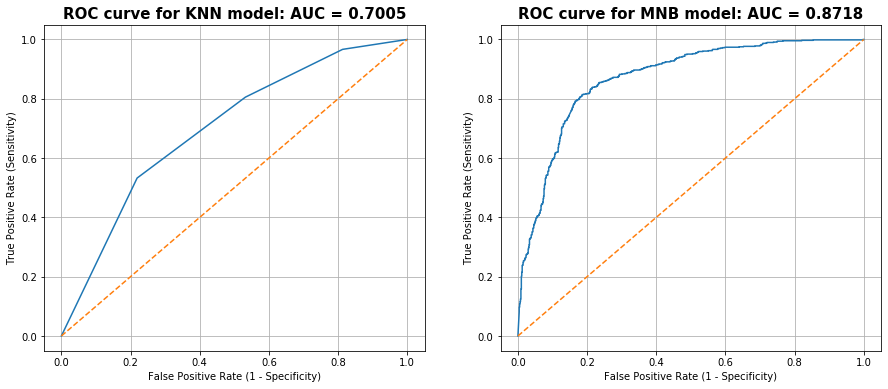

In [64]:
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, proba_knn[:,1])
fpr_mnb, tpr_mnb, thresholds_mnb = metrics.roc_curve(y_test, proba_mnb[:,1])

fig, ax = plt.subplots(1,2,figsize= (15,6))

ax[0].plot(fpr_knn, tpr_knn)
ax[0].set_title('ROC curve for KNN model: AUC = {}'.format(round(roc_auc_score(y_test,
              proba_knn[:,1]),4)), weight = 'bold', fontsize = 15)
ax[0].set_xlabel('False Positive Rate (1 - Specificity)')
ax[0].set_ylabel('True Positive Rate (Sensitivity)')
ax[0].grid(True)
ax[0].plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

ax[1].plot(fpr_mnb, tpr_mnb)
ax[1].set_title('ROC curve for MNB model: AUC = {}'.format(round(roc_auc_score(y_test,
              proba_mnb[:,1]),4)), weight = 'bold', fontsize = 15)
ax[1].set_xlabel('False Positive Rate (1 - Specificity)')
ax[1].set_ylabel('True Positive Rate (Sensitivity)')
ax[1].grid(True)
ax[1].plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--');

## Conclusion

During modeling I have tried Multinomial Naive Bayes, Gaussian Naive Bayes, Logistic Regression and K Nearest Neighbors. Logistic Regression was abandoned right away for it was terribly overfit. The two models picked by me for further analysis were K Nearest Neighbors and Multinomial Naive Bayes for they had the best accuracy scores. Through evaluation I concluded that my Multinomial Naive Bayes model has performed the best all around. It predicts with around 80% accuracy and has the highest AUC score. Using this model, I went ahead and wrote a code that will predict whether an input belongs in a depressed or bipolar subreddit. I also, took a step further and have a code that will predict as you type and adjust the predictions accordingly. 